In [29]:
import os

# Change working directory to the BAYES folder
os.chdir(r'C:\Users\solom\Desktop\BAYES')

In [ ]:
#counts, bins, bars = plt.hist(x)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import optimize
import scipy
import bayesian_model as bm
import plotting
import emcee

data = pd.read_csv('C:/Users/solom/Desktop/BAYES/dielectron.csv')

data = data.dropna()
data = data[(data['Q1'] + data['Q2']) == 0]

path = 'C:/Users/solom/Desktop/BAYES/'
path_plots = 'C:/Users/solom/Desktop/BAYES/Plots/'

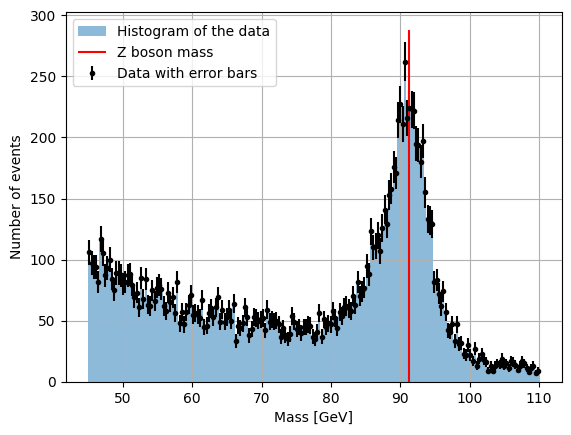

In [31]:
M_data = data['M'].values
#plt.hist(M_data, bins=200, range=(4, 125), alpha=0.5, label='Data')

y, bins, _ = plt.hist(M_data, bins=200, range=(45,110), alpha=0.5, label='Histogram of the data')
x = 0.5*(bins[1:]+bins[:-1])
y_errors = np.sqrt(y)  # Assuming Poisson statistics for the errors ----MAYBE ASK ABOUT THIS----

plt.errorbar(x, y, yerr=y_errors, fmt='.', color = 'k', label='Data with error bars')
plt.vlines(91.1876, 0, 1.1*np.max(y), color='r', label='Z boson mass')

plt.grid()
plt.xlabel('Mass [GeV]')
plt.ylabel('Number of events')

plt.legend()
plt.show()

counts = y
energies = x
counts_err = y_errors

<ErrorbarContainer object of 3 artists>

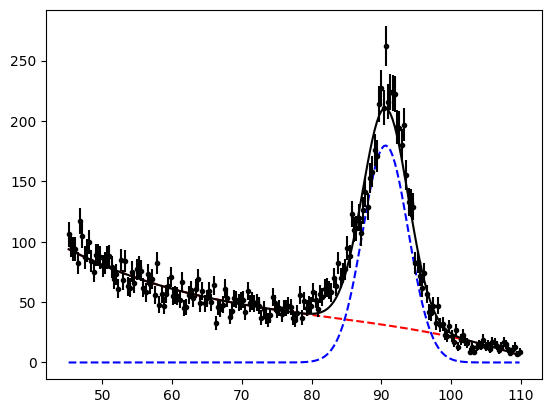

In [32]:
def background_poly3(x, c0, c1, c2, c3):
    return c0 + c1 * x + c2 * x**2 + c3 * x**3

def gauss_peak(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def model_poly3(x, a, mu, sigma, c0, c1, c2, c3):
    return gauss_peak(x, a, mu, sigma) + background_poly3(x, c0, c1, c2, c3)

popt, pcov = optimize.curve_fit(model_poly3, x, y, sigma=y_errors, p0 = [1000, 91, 2, 100, 100, 100, 100])
plt.plot(x, background_poly3(x, popt[3], popt[4], popt[5], popt[6]), label='Background', color = 'red', linestyle='--')
plt.plot(x, gauss_peak(x, popt[0], popt[1], popt[2]), label='Z-boson Peak', color = 'blue', linestyle='--')
plt.plot(x, model_poly3(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]), label='Fit', color = 'black')

plt.errorbar(x, y, yerr=y_errors, fmt='.', color = 'k', label='Data with error bars')

In [33]:
print(popt)
a = popt[0]
mu = popt[1]
sigma = popt[2]
c0 = popt[3]
c1 = popt[4]
c2 = popt[5]
c3 = popt[6]

[ 1.79690290e+02  9.06168819e+01  3.26176642e+00  3.93988685e+02
 -1.13865159e+01  1.28276965e-01 -5.16835031e-04]


In [38]:
sig = 0.01

myclip_a = 0
myclip_b = np.inf

my_mean = 90
my_std = 90*sig
a2, b2 = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std


a_prior = scipy.stats.norm(loc=200, scale=50)
mu_prior = scipy.stats.norm(loc=91.187, scale=2)
sigma_prior = scipy.stats.uniform(loc=2, scale=3)

c0_x = 3.93988685e+02
c1_x = -1.13865159e+01
c2_x = 1.28276965e-01
c3_x = -5.16835031e-04


c0_prior = scipy.stats.norm(loc=c0_x, scale=c0_x*sig)
c1_prior = scipy.stats.norm(loc=c1_x, scale=-c1_x*sig)
c2_prior = scipy.stats.norm(loc=c2_x, scale=c2_x*sig)
c3_prior = scipy.stats.norm(loc=c3_x, scale=-c3_x*sig)


priors = [a_prior, mu_prior, sigma_prior, 
          c0_prior, c1_prior, c2_prior, c3_prior]

def log_prior_probability(a, mu, sigma, c0, c1, c2, c3):
    return a_prior.logpdf(a1) + mu_prior.logpdf(mu1)+ sigma_prior.logpdf(sigma1) + \
        c0_prior.logpdf(c0)+ c1_prior.logpdf(c1)+ c2_prior.logpdf(c2)+ c3_prior.logpdf(c3)

[[ 1.95238120e+02  9.23109033e+01  3.54873344e+00  3.96417932e+02
  -1.14839313e+01  1.29372403e-01 -5.09126321e-04]
 [ 1.73640611e+02  9.05993575e+01  3.71062472e+00  3.90688512e+02
  -1.13910397e+01  1.30312549e-01 -5.24060984e-04]
 [ 1.83920765e+02  9.33763062e+01  4.47188354e+00  4.01234735e+02
  -1.14043379e+01  1.29941843e-01 -5.14164040e-04]
 [ 2.07556519e+02  9.24663847e+01  3.46013357e+00  4.03112906e+02
  -1.16452453e+01  1.26333292e-01 -5.19070737e-04]
 [ 1.99068614e+02  9.06377998e+01  4.67436380e+00  3.93168072e+02
  -1.13537618e+01  1.28686420e-01 -5.15639071e-04]
 [ 2.24176439e+02  9.20570185e+01  3.18518237e+00  3.93929692e+02
  -1.15908819e+01  1.24449219e-01 -5.10670196e-04]
 [ 2.38448258e+02  9.68107568e+01  4.23383434e+00  3.95121630e+02
  -1.13897936e+01  1.28640227e-01 -5.22722282e-04]
 [ 2.68312142e+02  9.16909903e+01  3.65827179e+00  3.98969040e+02
  -1.15543466e+01  1.28194406e-01 -5.23667744e-04]
 [ 2.57363240e+02  9.17860047e+01  3.87147526e+00  4.01462260e+0

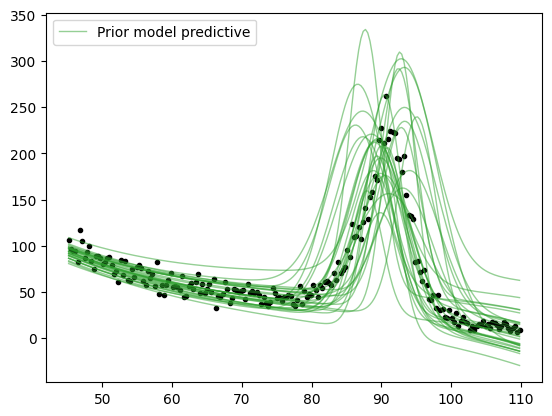

In [35]:
def sample_prior(n_sample, priors):
    """Sample n_sample times from the prior distribution."""
    
    return np.array([prior.rvs(n_sample) for prior in priors]).T

# Fix the pseudo random number generator seed for reproducibility
np.random.seed(3)

# Evaluate the mode3 at the prior sample parameters
prior_model_predictive = np.array(
    [model_poly3(x, *parameters) for parameters in sample_prior(n_sample=30, priors=priors)]
)

print(sample_prior(n_sample=30, priors=priors))

style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'black')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

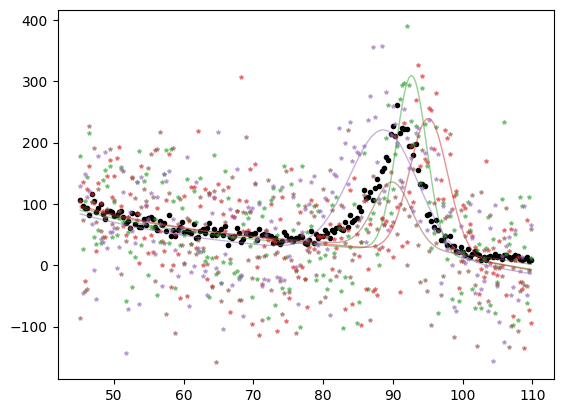

In [36]:
sigma_y = 70
prior_predictive = (
    prior_model_predictive
    + sigma_y*np.random.normal(size=prior_model_predictive.shape)
)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)

MAP results
[ 1.88576608e+02  9.08360893e+01  3.09698866e+00  3.94210222e+02
 -1.13766548e+01  1.28324396e-01 -5.16869759e-04]


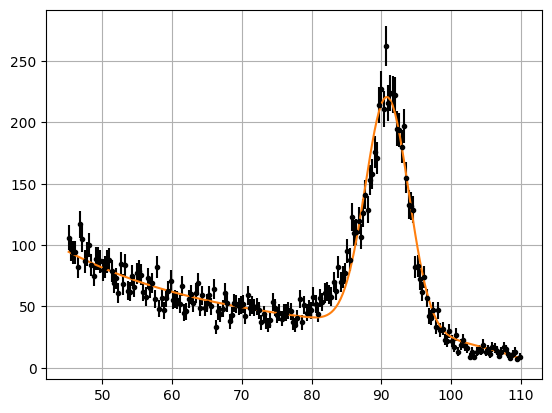

In [ ]:
def log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y):
    return (
        log_likelihood_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y)
        + log_prior_probability(a1, mu1, sigma1, a2, mu2, sigma2, b, k)
    )
    
def negative_log_posterior(theta, x, sigma_y, y):
    a1, mu1, sigma1, a2, mu2, sigma2, b, k = theta
    return -log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y)

MAP_result = scipy.optimize.minimize(
    fun=negative_log_posterior,
    x0=(410, 91, 3, 700, 15, 7.5, 380, 0.025),
    args=(x, sigma_y, y)
)
MAP_results = MAP_result.x

MAP_a1 = MAP_results[0]
MAP_mu1 = MAP_results[1]
MAP_sigma1 = MAP_results[2]
MAP_a2 = MAP_results[3]
MAP_mu2 = MAP_results[4]
MAP_sigma2 = MAP_results[5]
MAP_b = MAP_results[6]
MAP_k = MAP_results[7]

print("MAP results")
print(MAP_results)


In [41]:
np.random.seed(4)

# emcee requires some extra settings to run
n_param = 7       # Number of parameter we are sampling
n_walker = 30     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 8000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
# theta_init = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) \
#     + 0.1*np.random.normal(size=(n_walker, n_param))
    
theta_init = np.column_stack([
    a_prior.rvs(size=n_walker),
    mu_prior.rvs(size=n_walker),
    sigma_prior.rvs(size=n_walker),
    c0_prior.rvs(size=n_walker),
    c1_prior.rvs(size=n_walker),
    c2_prior.rvs(size=n_walker),
    c3_prior.rvs(size=n_walker),
])

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=bm.log_posterior_probability,
    args=(x, y, sigma_y, model_poly3, priors)
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)


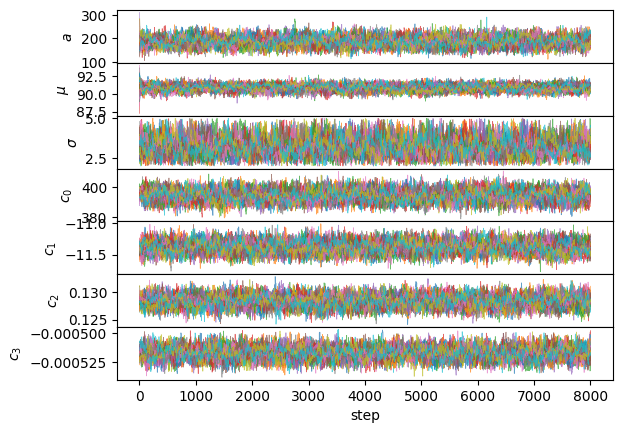

In [42]:
chain = sampler.get_chain()

n_walker = 30
param_names = [r"$a$", r"$\mu$", r"$\sigma$", r"$c_0$", r"$c_1$", r"$c_2$", r"$c_3$"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

In [43]:
tau = emcee.autocorr.integrated_time(chain)
print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
 print(f"{name}: {iat:.1f}")

Integrated auto-correlation time
$a$: 73.6
$\mu$: 76.8
$\sigma$: 80.0
$c_0$: 85.0
$c_1$: 80.9
$c_2$: 77.1
$c_3$: 68.5


In [45]:
max_autocorr = max(tau)
burn_in = int(10*max_autocorr)
thin = int(max_autocorr/2)

n_param = 7
chain = chain[burn_in::thin].reshape(-1, n_param)

#chain = sampler.get_chain(discard=1500, thin=10, flat=True)


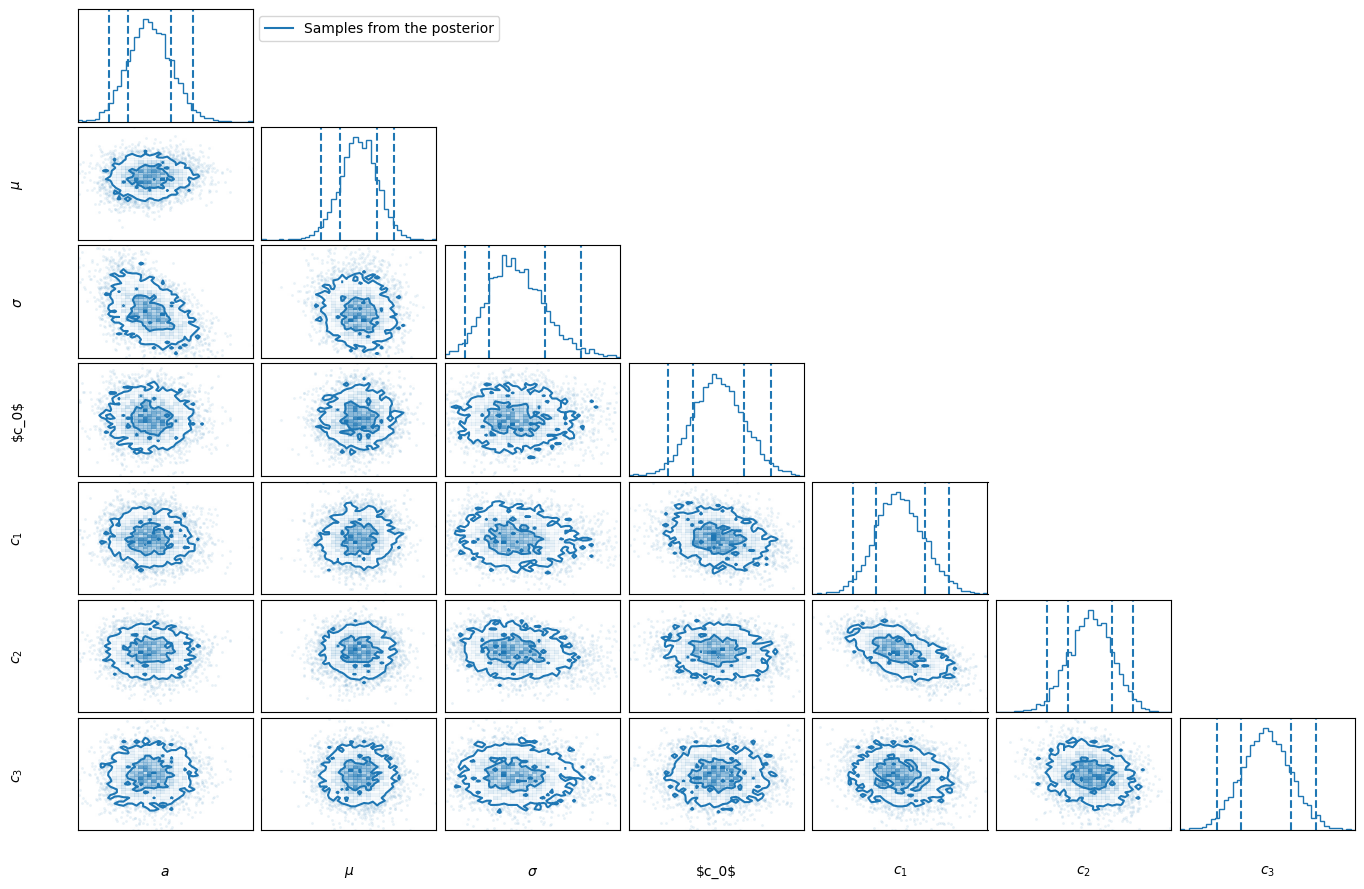

In [46]:
import corner
fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=[r"$a$", r"$\mu$", r"$\sigma$", r"\$c_0$", r"$c_1$", r"$c_2$", r"$c_3$"],
    color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
)
fig.get_axes()[0].plot([], [], c="C0", label="Samples from the posterior")
#fig.get_axes()[0].plot([], [], c="C1", label="True parameters")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))

# for ax in fig.get_axes():
#     ax.xaxis.label.set_size(12)  # Optional: Adjust font size if needed
#     ax.yaxis.label.set_size(12)
#     ax.xaxis.labelpad = 30       # Adjust label padding for x-axis
#     ax.yaxis.labelpad = 30       # Adjust label padding for y-axis

for ax in fig.get_axes():
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

fig.set_size_inches(14, 9)



<ErrorbarContainer object of 3 artists>

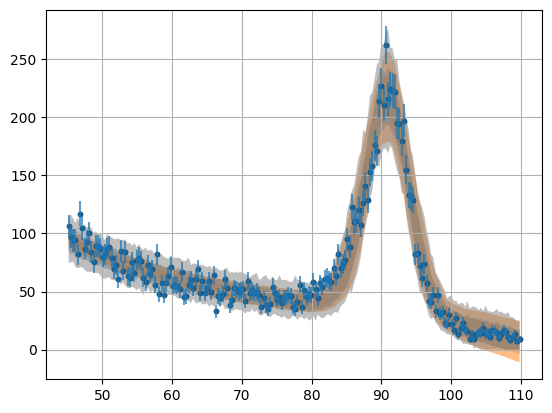

In [50]:
def sample_posterior(x, y, chain, model, seed=15, n_samples=200, plot=True):
    
    np.random.seed(seed)
    flat_chain = chain.reshape(-1, chain.shape[-1])
    chain_samples = flat_chain[np.random.choice(chain.shape[0], size=n_samples)]

    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(x, *sample) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    if plot == True:
        plt.grid()
        plt.fill_between(x, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1",
                    label="Model predictive distribution")
        plt.fill_between(x, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1")
        plt.plot(x, y, ".", color = 'black')
        
    return chain_samples, model_predictive

chain_samples, model_predictive = sample_posterior(x, y, chain, model_poly3)
def predict(params, x):
    lambda_model = model_poly3(x, *params)
    lambda_model = np.maximum(lambda_model, 0)

    # Draw from the Poisson distribution using the computed lambda
    return np.random.poisson(lam=lambda_model)

posterior_predictive = np.array(
        [predict(sample, x) for sample in chain_samples])

quantiles = np.percentile(posterior_predictive, [2.5, 16, 84, 97.5], axis=0)

plt.fill_between(x, quantiles[0], quantiles[-1], alpha=0.5, facecolor="C17",
                    label="Model predictive distribution")
plt.fill_between(x, quantiles[1], quantiles[-2], alpha=0.5, facecolor="C17")
plt.errorbar(x, y, yerr=y_errors, fmt=".", color="C10", label="Data", alpha=0.7)

In [51]:
def chi_squared(y, mu):
    return np.sum((y - mu)**2/mu)

def test_statistic(y, theta, x, sigma_y, model):
    mu = model(x, *theta)
    t = chi_squared(y, mu)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))
        
    t_data = np.array(t_data)
    t_rep = np.array(t_rep)
    
    print(t_data)
    print(t_rep)
    
    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data



ppd = posterior_predictive

PPD_PTE_gauss_exp, t_rep_gauss_exp, t_gauss_exp = ppd_model_check(
                                    test_statistic=lambda y, theta: test_statistic(y, theta, x, y_errors, model_poly3),
                                    y=y,
                                    ppd=ppd,
                                    ppd_params=chain_samples
                                                                  )

print(f"Gauss + Exp: PPD PTE={PPD_PTE_gauss_exp:.3f}")

[   577.83256367 -25228.69752692   1392.81647691    794.94054917
    496.94101832   1022.35795774    419.28202852    499.02238528
  -1362.2556631     382.87891756    820.31522995    497.77275866
    570.03960004   2089.49681018    353.29208422    484.19670962
    794.74685147    874.54860594   1075.31624839    528.59444303
    487.49604048    592.22290646  -1104.40821083    423.56907617
   1691.63590488    759.64705672    491.95629607    618.21532555
    760.32174458    562.85850931    820.31522995    672.95191502
    797.37537764   1275.49130995    424.21229884   -570.02064717
    441.93523015    483.20462406    234.42258612    566.27999817
    329.63674016    524.07886748    496.10231498    394.10158582
    810.63130711    482.22857509    502.50910362    595.23852198
    346.44941827    482.73020072    376.03281343  27808.11081532
   -223.70164366    978.93800803   1012.0419857    2320.41216044
 -10094.71614067  28592.94756396  -1950.28058223    648.64112312
   2089.49681018    349.3

In [52]:
np.save('chain_popeyes.npy', sampler.get_chain())